# Importing Libraries

In [1]:
# import tensorflow, datasets & disable deprecation warnings
import tensorflow as tf
import tensorflow_datasets as tfds

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

# Improve progress for bard display
import tqdm
import tqdm.auto

tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)

2024-09-23 22:50:54.011223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 22:50:54.026906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 22:50:54.031093: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-23 22:50:54.041593: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.17.0


/home/tensorflow/miniconda3/envs/.tf217/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import the Fashion MNIST dataset

In [2]:
dataset, metadata = tfds.load("fashion_mnist", as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset["train"], dataset["test"]

I0000 00:00:1727121056.905864   77260 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727121056.910167   77260 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727121056.910208   77260 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727121056.912447   77260 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727121056.912484   77260 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

## Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images

In [3]:
class_names = metadata.features["label"].names
print(f"Class names: {class_names}")

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Explore the data

In [4]:
num_train_examples = metadata.splits["train"].num_examples
num_test_examples = metadata.splits["test"].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


# Data preprocessing

In [5]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels


# The map function applies the normalize function to each element in the train and test datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# The first time you use the dataset, the images will be loaded from disk Caching will keep them in memory, making training faster
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

# Explore the processed data

2024-09-23 22:50:57.421018: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-23 22:50:57.421135: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


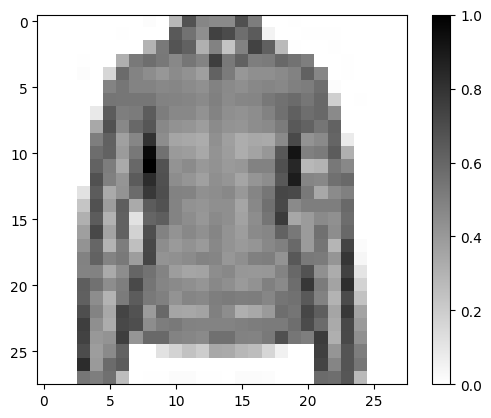

In [6]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
    image = image.numpy().reshape((28, 28))
    break


# Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

# Verify that the data is in the correct format by displaying first 25 images

2024-09-23 22:50:57.798522: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-23 22:50:57.798760: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-09-23 22:50:57.810100: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

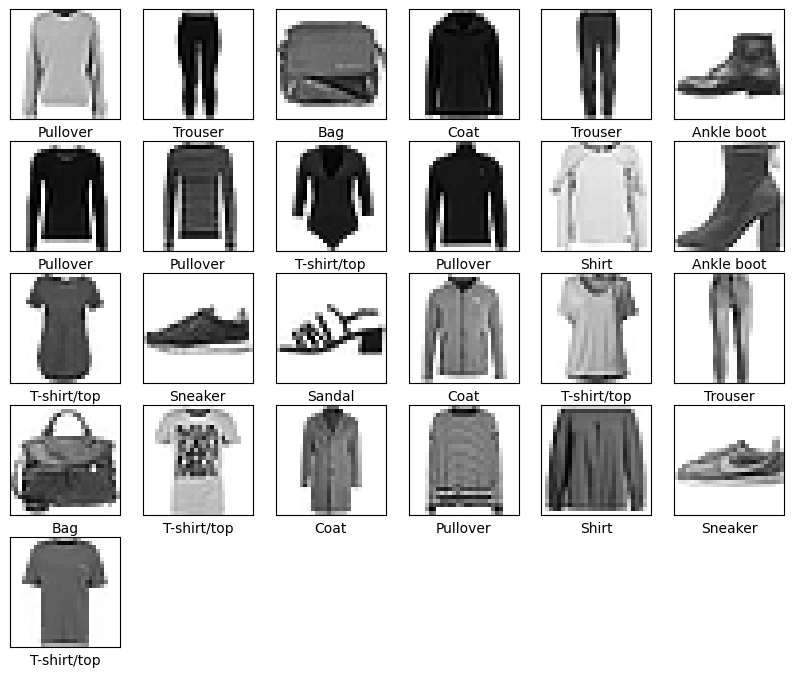

In [7]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape((28, 28))
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

# Build the model

## Setup the layers

In [8]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax),
    ]
)

/home/tensorflow/miniconda3/envs/.tf217/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compile the model

In [9]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

# Train the model

In [10]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [11]:
model.fit(
    train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples / BATCH_SIZE)
)

Epoch 1/5


I0000 00:00:1727121061.190430   77343 service.cc:146] XLA service 0x7efe18005040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727121061.190493   77343 service.cc:154]   StreamExecutor device (0): Quadro T2000, Compute Capability 7.5
2024-09-23 22:51:01.204258: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-23 22:51:01.276806: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  79/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5398 - loss: 1.3535

I0000 00:00:1727121062.022408   77343 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7852 - loss: 0.6247
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8616 - loss: 0.3852
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8760 - loss: 0.3361
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8827 - loss: 0.3177
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8890 - loss: 0.2987


# Evaluate accuracy

In [12]:
test_loss, test_accuracy = model.evaluate(
    test_dataset, steps=math.ceil(num_test_examples / 32)
)
print("Accuracy on test dataset:", test_accuracy)

 38/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8794 - loss: 0.3505

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8747 - loss: 0.3489
Accuracy on test dataset: 0.8712999820709229


# Make predictions and explore

In [13]:
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


2024-09-23 22:51:27.634920: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
predictions.shape

(32, 10)

In [15]:
predictions[0]

array([8.79628260e-06, 9.96056770e-06, 1.63898524e-02, 4.03827016e-06,
       9.68321085e-01, 2.90912539e-08, 1.52176395e-02, 7.46573470e-10,
       4.87134603e-05, 7.87052298e-11], dtype=float32)

In [16]:
np.argmax(predictions[0])

4

In [17]:
test_labels[0]

4

# Plotting Function

In [18]:
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[..., 0], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = "blue"
    else:
        color = "red"

    plt.xlabel(
        "{} {:2.0f}% ({})".format(
            class_names[predicted_label],
            100 * np.max(predictions_array),
            class_names[true_label],
        ),
        color=color,
    )


def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color("red")
    thisplot[true_label].set_color("blue")

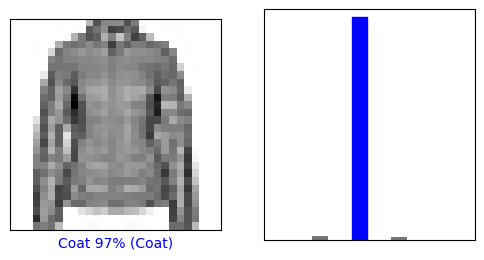

In [19]:
i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

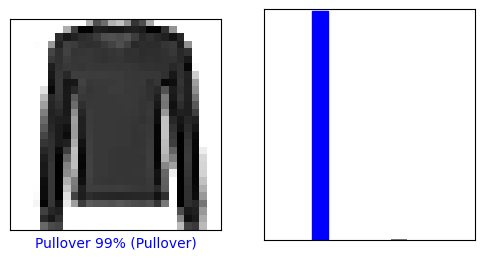

In [20]:
i = 12
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions, test_labels)

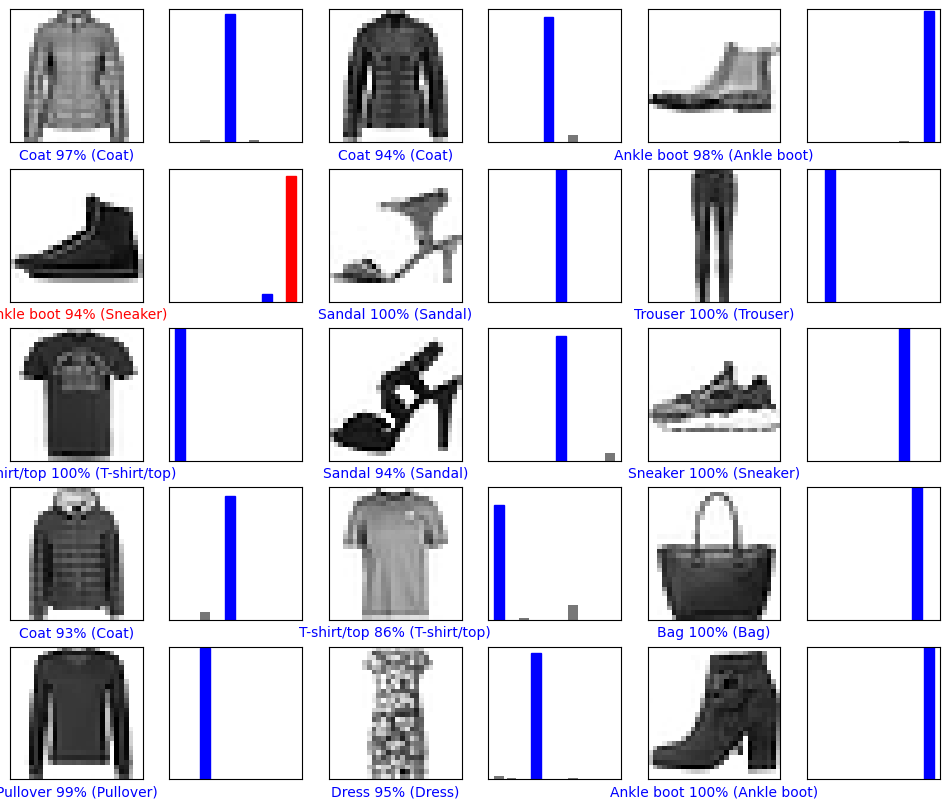

In [21]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions, test_labels)

In [22]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [23]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [24]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
[[8.79628260e-06 9.96057770e-06 1.63898524e-02 4.03827016e-06
  9.68321085e-01 2.90913089e-08 1.52176395e-02 7.46573470e-10
  4.87134603e-05 7.87052298e-11]]


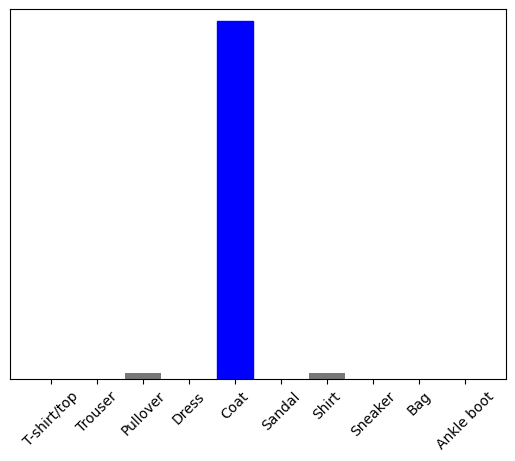

In [25]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)